# 6d reconstruction scan

In [1]:
import os
import sys
sys.path.append("../")

#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


## define the diagnostic

In [2]:
import pandas as pd
import time
from plugins.interfaces.diagnostics import EPICSImageDiagnostic, ROI

screen_name = "13ARV1"
save_image_location = "/home/awa/awa_data/12-05_6DReconstruction/"
TESTING = False
DYG14_IP = "192.168.2.111"
DYG15_IP = "192.168.2.139"
charge_pvs = ["AWAVXI11ICT:Ch4"]

kwargs = dict(
    extra_pvs=charge_pvs,
    visualize=False,
    n_fitting_restarts=60,
    target_charge=1.2e-9, # multiply this by 0.6 for actual charge
    target_charge_pv=charge_pvs[0],
    charge_atol=0.1e-9,
    testing=False
)

dyg14_roi = ROI(
    xcenter = 567,
    ycenter = 806,
    xwidth = 700,
    ywidth = 700
)
dyg15_roi = ROI(
    xcenter = 595,
    ycenter = 1071,
    xwidth = 700,
    ywidth = 700
)

DYG14 = EPICSImageDiagnostic(
    screen_name=screen_name,
    resolution_suffix=None,
    save_image_location=save_image_location,
    roi=dyg14_roi,
    **kwargs
)

DYG15 = EPICSImageDiagnostic(
    screen_name=screen_name,
    resolution_suffix=None,
    save_image_location=save_image_location,
    roi=dyg15_roi,
    **kwargs
)

def set_camera(ip_address, testing=False):
    if not testing:
        from epics import caput
        # stop the current camera
        caput("13ARV1:cam1:Acquire", 0)
        time.sleep(1)
        # set the new camera IP address
        caput("13ARV1:cam1:GC_SetCameraName", ip_address)
        time.sleep(1)
        # start the new camera
        caput("13ARV1:cam1:Acquire", 1)

        time.sleep(10)



please shutter beam


please un-shutter beam


3.480264999369773e-10
charge error 3.5e-10 outside atol 1e-10
1.4570437882021141e-10
charge error 1.5e-10 outside atol 1e-10
1.7101102566500413e-10
charge error 1.7e-10 outside atol 1e-10
1.314407961608318e-10
charge error 1.3e-10 outside atol 1e-10
6.107329095887489e-10
charge error 6.1e-10 outside atol 1e-10
4.766189561618109e-10
charge error 4.8e-10 outside atol 1e-10
1.3516654697924145e-10
charge error 1.4e-10 outside atol 1e-10
5.309195788481037e-11
displaying image
fitting image


{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': nan,
 'total_intensity': 64552137.599999994,
 'log10_total_intensity': 7.809910628206057,
 'AWAVXI11ICT:Ch4': 1.1469080421151896e-09}

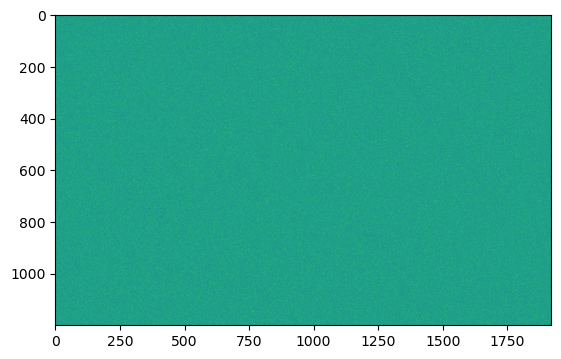

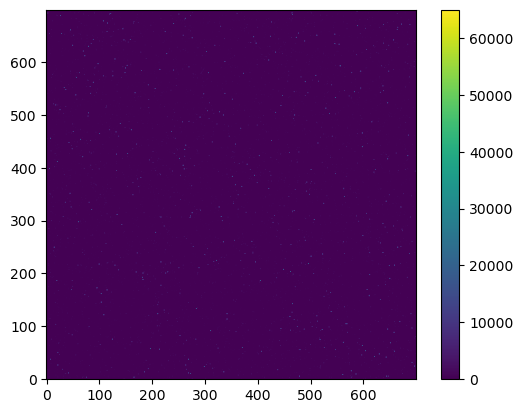

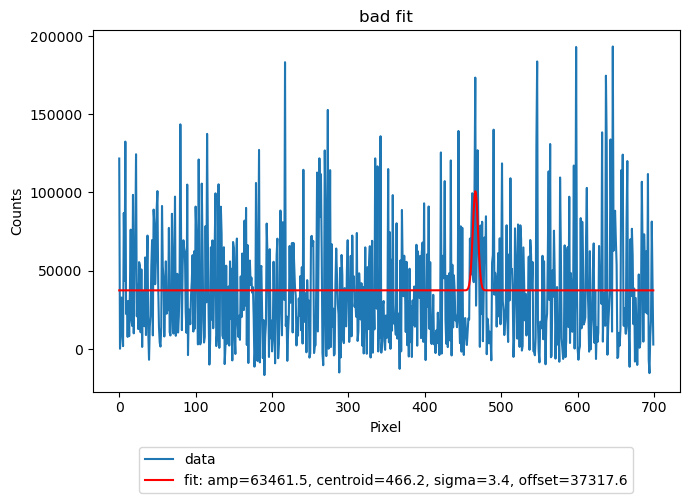

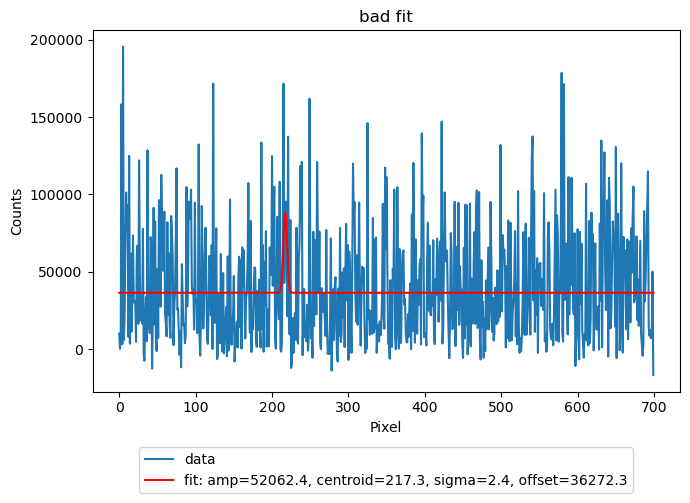

In [4]:
import matplotlib.pyplot as plt
set_camera(DYG14_IP)

print("please shutter beam")
input()
DYG14.measure_background(file_location="DYG14")

print("please un-shutter beam")
input()

plt.imshow(DYG14.background_image)
DYG14.test_measurement()

please shutter beam


please un-shutter beam


2.774083469461661e-10
charge error 2.8e-10 outside atol 1e-10
2.394074171694357e-10
charge error 2.4e-10 outside atol 1e-10
1.0462248750315607e-10
charge error 1e-10 outside atol 1e-10
9.847504368242475e-11
displaying image
fitting image


{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': 209.0770732443325,
 'total_intensity': 148048716.79999995,
 'log10_total_intensity': 8.170404647530152,
 'AWAVXI11ICT:Ch4': 1.2984750436824247e-09}

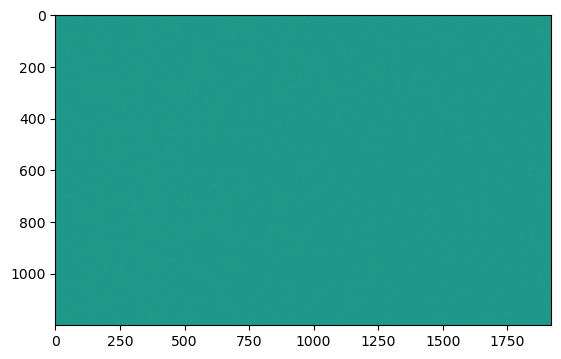

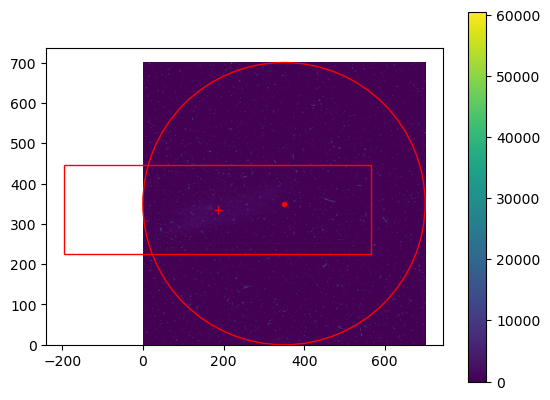

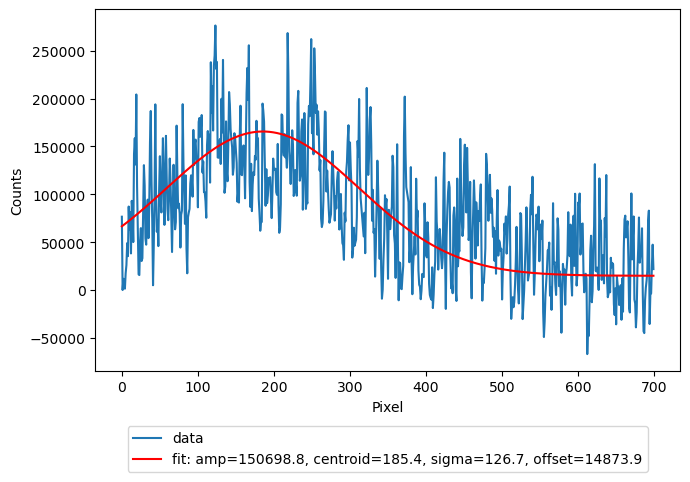

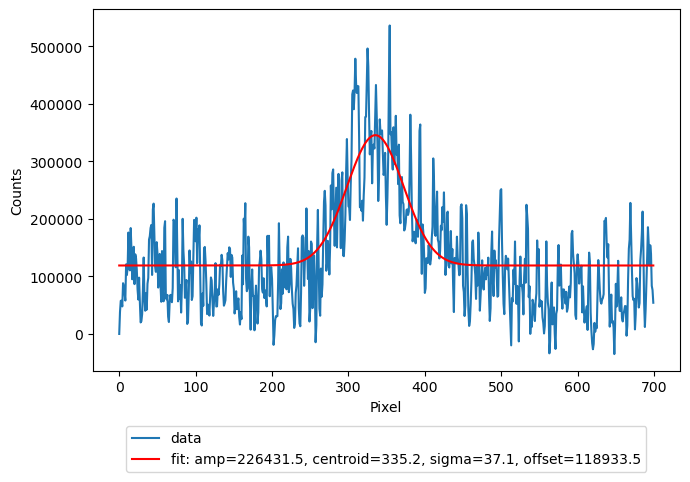

In [5]:
set_camera(DYG15_IP)

print("please shutter beam")
input()
DYG15.measure_background(file_location="DYG15")

print("please un-shutter beam")
input()

plt.imshow(DYG15.background_image)
DYG15.test_measurement()

### Define the evaluator

In [10]:
from epics import caput, caget
from xopt import Evaluator
import time
import numpy as np

def evaluate_function(inputs: dict, diagnostic, testing=False) -> dict:
    # caput values
    if not testing:
        for name, val in inputs.items():
            caput(name, val)
            print(name, val)

    # wait for changes to occur
    time.sleep(2)

    results = diagnostic.measure_beamsize(5, fit_image=False, **inputs)

    return results | inputs

evaluator = Evaluator(function=evaluate_function)

### Set up scan

In [12]:
# quad strength pv values
import numpy as np
x = np.linspace(-1,1,5)
quad_pv_name = "AWA:Bira3Ctrl:Ch10"
tdc_pv_name = "pi:QBCR1:Ch7:EnablePulse"
dipole_pv_name = "AWA:Bira4Ctrl:Ch01"
tdc_vals = {"OFF":0, "ON":1} # off/on values
dipole_vals = {"OFF":0, "ON":-5.63} # off/on vals

def do_quad_scan(k, pv_dict, diagnostic, testing=False):
    q_scan_data = []
    print("doing quad scan")
    for ele in k:
        # add tcav/dipole settings to quad settings
        total_pvs = pv_dict | {quad_pv_name:ele}
        print(total_pvs)

        # do measurement
        result = evaluate_function(total_pvs, diagnostic, testing)
        q_scan_data += [result]

    return q_scan_data

data = []

# do quad scan with dipole off
set_camera(DYG14_IP, testing=TESTING)
for tdc_state in ["OFF","ON"]:
    # set dipole
    caput(dipole_pv_name, dipole_vals["OFF"])
    time.sleep(10)
    
    q_scan_results = do_quad_scan(
        x,
        {tdc_pv_name: tdc_vals[tdc_state], dipole_pv_name: dipole_vals["OFF"]},
        DYG14,
        TESTING
    )
    data = data + q_scan_results

import yaml
import json

pd_data = pd.DataFrame(data)

# save dataframe to file
with open(os.path.join(save_image_location, 'data.yml'), 'w') as outfile:
    yaml.dump(json.loads(pd_data.to_json(orient="records"))
, outfile, default_flow_style=False)

input()
time.sleep(10)

# do quad scan with dipole on
set_camera(DYG15_IP, testing=TESTING)
for tdc_state in ["OFF","ON"]:
    # set dipole
    caput(dipole_pv_name, dipole_vals["ON"])
    time.sleep(10)
    q_scan_results = do_quad_scan(
        x,
        {tdc_pv_name: tdc_vals[tdc_state], dipole_pv_name: dipole_vals["ON"]},
        DYG14,
        TESTING
    )
    data = data + q_scan_results

pd_data = pd.DataFrame(data)

# save dataframe to file
with open(os.path.join(save_image_location, 'data.yml'), 'w') as outfile:
    yaml.dump(json.loads(pd_data.to_json(orient="records"))
, outfile, default_flow_style=False)

doing quad scan
{'pi:QBCR1:Ch7:EnablePulse': 0, 'AWA:Bira4Ctrl:Ch01': 0, 'AWA:Bira3Ctrl:Ch10': -1.0}
pi:QBCR1:Ch7:EnablePulse 0
AWA:Bira4Ctrl:Ch01 0
AWA:Bira3Ctrl:Ch10 -1.0
2.7846881195944875e-10
charge error 2.8e-10 outside atol 1e-10
2.738311938761818e-10
charge error 2.7e-10 outside atol 1e-10
9.14630311438554e-11
2.3531872760804813e-10
charge error 2.4e-10 outside atol 1e-10
1.7443370969064062e-10
charge error 1.7e-10 outside atol 1e-10
7.023743627025412e-11
2.8238772240542765e-10
charge error 2.8e-10 outside atol 1e-10
9.16165995958382e-11
7.718503900588116e-11
2.2289909047185443e-10
charge error 2.2e-10 outside atol 1e-10
1.787628574266943e-10
charge error 1.8e-10 outside atol 1e-10
1.7742337285431938e-11
{'pi:QBCR1:Ch7:EnablePulse': 0, 'AWA:Bira4Ctrl:Ch01': 0, 'AWA:Bira3Ctrl:Ch10': -0.5}
pi:QBCR1:Ch7:EnablePulse 0
AWA:Bira4Ctrl:Ch01 0
AWA:Bira3Ctrl:Ch10 -0.5
4.83059092517222e-10
charge error 4.8e-10 outside atol 1e-10
1.5920919492511983e-10
charge error 1.6e-10 outside atol 1e-1

doing quad scan
{'pi:QBCR1:Ch7:EnablePulse': 0, 'AWA:Bira4Ctrl:Ch01': -5.63, 'AWA:Bira3Ctrl:Ch10': -1.0}
pi:QBCR1:Ch7:EnablePulse 0
AWA:Bira4Ctrl:Ch01 -5.63
AWA:Bira3Ctrl:Ch10 -1.0
2.828186733210305e-10
charge error 2.8e-10 outside atol 1e-10
2.3525941770763868e-11
1.4956475075922598e-10
charge error 1.5e-10 outside atol 1e-10
3.941125155593494e-10
charge error 3.9e-10 outside atol 1e-10
1.969917484866773e-10
charge error 2e-10 outside atol 1e-10
2.0558520130494031e-10
charge error 2.1e-10 outside atol 1e-10
2.0164330830707334e-10
charge error 2e-10 outside atol 1e-10
4.358440376592888e-11
1.3072765616753154e-11
2.0151949429540762e-10
charge error 2e-10 outside atol 1e-10
5.599096486675794e-11
5.754582022494542e-11
{'pi:QBCR1:Ch7:EnablePulse': 0, 'AWA:Bira4Ctrl:Ch01': -5.63, 'AWA:Bira3Ctrl:Ch10': -0.5}
pi:QBCR1:Ch7:EnablePulse 0
AWA:Bira4Ctrl:Ch01 -5.63
AWA:Bira3Ctrl:Ch10 -0.5
2.678698690331982e-11
2.811093489184882e-10
charge error 2.8e-10 outside atol 1e-10
1.522273696777243e-10
char

CA.Client.Exception...............................................
    Context: "192.168.0.167:5064"
    Source File: ../tcpiiu.cpp line 926
    Current Time: Tue Dec 05 2023 17:53:43.557242803
..................................................................
CA.Client.Exception...............................................
    Context: "192.168.0.166:5064"
    Source File: ../tcpiiu.cpp line 926
    Current Time: Tue Dec 05 2023 17:53:47.375463769
..................................................................


In [17]:
import yaml
import json

